In [1]:
import logging
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from src.civicsim.common.utils import get_census_data

In [2]:
from os import getenv
from dotenv import load_dotenv
load_dotenv("./.env")

True

In [3]:
pd.set_option('display.max_columns', 100)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [4]:
CENSUS_API_KEY = getenv("CENSUS_API_KEY")

In [5]:
## Potential groups for analysis:
acs_groups = {"age_sex_educational_attainment": "B15001",
              "age_sex": "B01001",
              "estimated_yearly_income": "B25121"
              }

In [8]:
desired_var_group = acs_groups["age_sex"] # Age
STATEFP = '47' # TN

# 11 counties around BOC
COUNTYFPS = ['097', '075', '023', '069', '157', '167', '033', '113', '045', '053', '047']
BOC_TOTAL_POPULATION = 10_000

ACS5 = "https://api.census.gov/data/2022/acs/acs5"

In [9]:
census_vars_path = "./data/variables.json"
with open(census_vars_path) as f:
    census_vars = json.load(f)
census_vars = census_vars['variables']
census_vars_df = pd.DataFrame.from_dict(census_vars, orient='index')

census_vars_df = census_vars_df[census_vars_df['group'] == desired_var_group]
census_vars_df = census_vars_df.transpose()

# Rename texts
# Replace '!!' with '_' in the data as well, if needed
census_vars_df = census_vars_df.replace('Estimate!!Total:!!Male:!!', 'Estimate_Total_Male_', regex=True)
census_vars_df = census_vars_df.replace('Estimate!!Total:!!Female:!!', 'Estimate_Total_Female_', regex=True)
census_vars_df = census_vars_df.replace(' to ', '_to_', regex=True)
census_vars_df = census_vars_df.replace(' and ', '_and_', regex=True)
census_vars_df = census_vars_df.replace(' years', '_years', regex=True)

# Final name mapping
rename_dict = census_vars_df.loc['label'].to_dict()

# Get dataset from available API
* [Available APIs](https://www.census.gov/data/developers/data-sets.html)
* American Community Survey 5-Year Data (2009-2022)
    * Data available down to the block-group level. Covers a range of topics about social, economic, demographic, and housing characteristics of the U.S. population. 

In [10]:
# census_data_df = get_census_data(CENSUS_API_KEY, ACS5, "B01001", "47", "097", "*", False)
# census_data_df.rename(columns=rename_dict, inplace=True)
# # Drop columns for margin of error, annotation of estimate, annotation of margin of error and margin of error
# # Select columns that end with 'M', 'EA', or 'MA'
# cols_to_drop = census_data_df.filter(regex='(M|EA|MA)$').columns

# # Drop the selected columns from the DataFrame
# census_data_df.drop(cols_to_drop, axis=1, inplace=True)

# # Convert columns containing "Estimate" in their names to float
# estimate_cols = [col for col in census_data_df.columns if 'Estimate' in col]
# census_data_df[estimate_cols] = census_data_df[estimate_cols].astype(float)

In [11]:
# # Sanity check
# tdf = census_data_df.head(1)
# tdf = tdf.T.reset_index()
# mask = tdf['index'].str.contains('Female')
# tdf[0] = tdf[mask][0].astype('int')

# assert (tdf[mask].sum(numeric_only=True)[0] // 2) == tdf[mask].iloc[1:].sum(numeric_only=True)[0]

# Gather for all county and merge

In [12]:
census_blocks_df = gpd.read_file("./data/censusblocks")
print(census_blocks_df.crs)
census_blocks_df = census_blocks_df[(census_blocks_df['COUNTYFP'].isin(COUNTYFPS)) & (census_blocks_df['STATEFP'] == STATEFP)]
census_blocks_df.head()

EPSG:4269


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
1458,47,157,011402,1,1500000US471570114021,471570114021,1,Block Group 1,BG,929721,0,"POLYGON ((-90.05500 35.13467, -90.05306 35.137..."
1460,47,157,011600,2,1500000US471570116002,471570116002,2,Block Group 2,BG,358416,0,"POLYGON ((-90.04716 35.11845, -90.04720 35.119..."
1461,47,157,021355,2,1500000US471570213552,471570213552,2,Block Group 2,BG,2428466,0,"POLYGON ((-89.78435 35.05921, -89.78208 35.059..."
1464,47,157,010210,3,1500000US471570102103,471570102103,3,Block Group 3,BG,720385,0,"POLYGON ((-89.98385 35.22790, -89.98333 35.228..."
1467,47,113,000900,1,1500000US471130009001,471130009001,1,Block Group 1,BG,660073,0,"POLYGON ((-88.80784 35.61746, -88.80637 35.617..."


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
29140,47,097,050100,2,1500000US470970501002,470970501002,2,Block Group 2,BG,150177077,11696451,"POLYGON ((-89.95790 35.58726, -89.95659 35.590..."
61877,47,097,050100,1,1500000US470970501001,470970501001,1,Block Group 1,BG,371385588,66967920,"POLYGON ((-89.95834 35.72656, -89.95377 35.731..."


<Axes: >

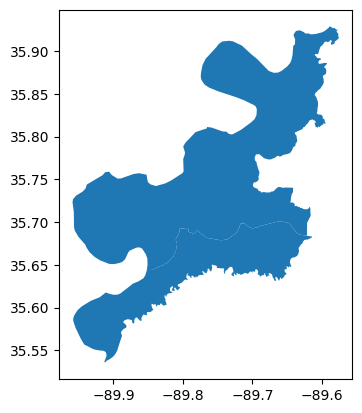

In [13]:
display(census_blocks_df.query("TRACTCE == '050100'"))
census_blocks_df.query("TRACTCE == '050100'").plot()

In [14]:
# Loop through all included counties

census_data_df_arr = []
for COUNTYFP in COUNTYFPS:
    logger.debug(f"Getting data for county {COUNTYFP}")
    census_data_df = get_census_data(CENSUS_API_KEY, ACS5, "B01001", "47", f"{COUNTYFP}", "*", False)
    census_data_df.rename(columns=rename_dict, inplace=True)
    # Drop columns for margin of error, annotation of estimate, annotation of margin of error and margin of error
    # Select columns that end with 'M', 'EA', or 'MA'
    cols_to_drop = census_data_df.filter(regex='(M|EA|MA)$').columns

    # Drop the selected columns from the DataFrame
    census_data_df.drop(cols_to_drop, axis=1, inplace=True)
    # Convert columns containing "Estimate" in their names to float
    estimate_cols = [col for col in census_data_df.columns if 'Estimate' in col]
    census_data_df[estimate_cols] = census_data_df[estimate_cols].astype(float)
    
    census_data_df_arr.append(census_data_df)

census_data_df = pd.concat(census_data_df_arr)

In [15]:
census_data_df['GEOID'] = census_data_df['state'] + census_data_df['county'] + census_data_df['tract'] + census_data_df['block group']
census_data_df.shape

(977, 57)

In [16]:
census_data_df = census_data_df.merge(census_blocks_df[["GEOID", "geometry"]], on="GEOID")
census_data_df = gpd.GeoDataFrame(census_data_df, geometry="geometry")

In [17]:
# Sanity check
census_data_df.sum(numeric_only=True)

Estimate!!Total:                           1315544.0
Estimate!!Total:!!Male:                     633167.0
Estimate_Total_Male_Under 5_years            42778.0
Estimate_Total_Male_5_to_9_years             44413.0
Estimate_Total_Male_10_to_14_years           47120.0
Estimate_Total_Male_15_to_17_years           26972.0
Estimate_Total_Male_18_and_19_years          17244.0
Estimate_Total_Male_20_years                  9221.0
Estimate_Total_Male_21_years                  7791.0
Estimate_Total_Male_22_to_24_years           25650.0
Estimate_Total_Male_25_to_29_years           46729.0
Estimate_Total_Male_30_to_34_years           43983.0
Estimate_Total_Male_35_to_39_years           39939.0
Estimate_Total_Male_40_to_44_years           39607.0
Estimate_Total_Male_45_to_49_years           38281.0
Estimate_Total_Male_50_to_54_years           39032.0
Estimate_Total_Male_55_to_59_years           38723.0
Estimate_Total_Male_60_and_61_years          16031.0
Estimate_Total_Male_62_to_64_years           2

In [18]:
census_data_df.head(1)

,NAME,Estimate!!Total:,Estimate!!Total:!!Male:,Estimate_Total_Male_Under 5_years,Estimate_Total_Male_5_to_9_years,Estimate_Total_Male_10_to_14_years,Estimate_Total_Male_15_to_17_years,Estimate_Total_Male_18_and_19_years,Estimate_Total_Male_20_years,Estimate_Total_Male_21_years,Estimate_Total_Male_22_to_24_years,Estimate_Total_Male_25_to_29_years,Estimate_Total_Male_30_to_34_years,Estimate_Total_Male_35_to_39_years,Estimate_Total_Male_40_to_44_years,Estimate_Total_Male_45_to_49_years,Estimate_Total_Male_50_to_54_years,Estimate_Total_Male_55_to_59_years,Estimate_Total_Male_60_and_61_years,Estimate_Total_Male_62_to_64_years,Estimate_Total_Male_65_and_66_years,Estimate_Total_Male_67_to_69_years,Estimate_Total_Male_70_to_74_years,Estimate_Total_Male_75_to_79_years,Estimate_Total_Male_80_to_84_years,Estimate_Total_Male_85_years_and_over,Estimate!!Total:!!Female:,Estimate_Total_Female_Under 5_years,Estimate_Total_Female_5_to_9_years,Estimate_Total_Female_10_to_14_years,Estimate_Total_Female_15_to_17_years,Estimate_Total_Female_18_and_19_years,Estimate_Total_Female_20_years,Estimate_Total_Female_21_years,Estimate_Total_Female_22_to_24_years,Estimate_Total_Female_25_to_29_years,Estimate_Total_Female_30_to_34_years,Estimate_Total_Female_35_to_39_years,Estimate_Total_Female_40_to_44_years,Estimate_Total_Female_45_to_49_years,Estimate_Total_Female_50_to_54_years,Estimate_Total_Female_55_to_59_years,Estimate_Total_Female_60_and_61_years,Estimate_Total_Female_62_to_64_years,Estimate_Total_Female_65_and_66_years,Estimate_Total_Female_67_to_69_years,Estimate_Total_Female_70_to_74_years,Estimate_Total_Female_75_to_79_years,Estimate_Total_Female_80_to_84_years,Estimate_Total_Female_85_years_and_over,GEO_ID,NAME,state,county,tract,block group,GEOID,geometry
0,Block Group 1; Census Tract 501; Lauderdale Co...,490.0,291.0,0.0,0.0,40.0,10.0,18.0,0.0,0.0,0.0,12.0,0.0,58.0,10.0,22.0,12.0,15.0,0.0,30.0,17.0,23.0,14.0,7.0,3.0,0.0,199.0,12.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,8.0,16.0,0.0,24.0,15.0,15.0,26.0,0.0,7.0,8.0,16.0,24.0,4.0,0.0,0.0,1500000US470970501001,Block Group 1; Census Tract 501; Lauderdale Co...,47,097,050100,1,470970501001,"POLYGON ((-89.95834 35.72656, -89.95377 35.731..."


In [19]:
# # Saving the data:
# census_data_df = census_data_df.drop(columns="NAME")
# census_data_df.to_file("./data/processed_block_age_sex.geojson")

In [20]:
# Load the data
census_data_df = gpd.read_file("./data/processed_block_age_sex.geojson")

Text(0.5, 1.0, 'Total Population per Census Tract')

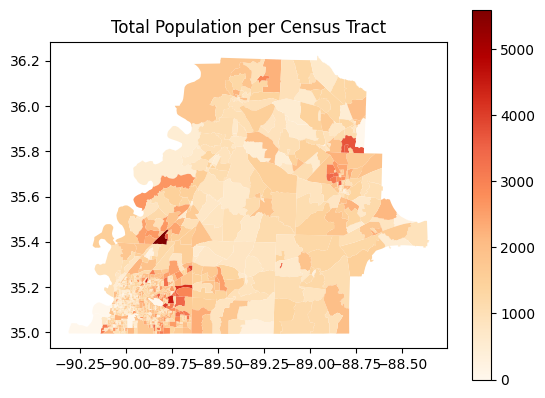

In [21]:
# Plotting heatmap for a data
# census_data_df.plot()
ax = census_data_df.plot(column='Estimate!!Total:', cmap='OrRd', legend=True)
ax.set_title("Total Population per Census Tract")

# Get percentages of population

In [22]:
ages_for_removal = [
               'Estimate_Total_Male_Under 5_years',
               'Estimate_Total_Male_5_to_9_years',
               'Estimate_Total_Male_10_to_14_years',
               'Estimate_Total_Male_15_to_17_years',
               'Estimate_Total_Male_67_to_69_years',
               'Estimate_Total_Male_70_to_74_years',
               'Estimate_Total_Male_75_to_79_years',
               'Estimate_Total_Male_80_to_84_years',
               'Estimate_Total_Male_85_years_and_over',
               'Estimate_Total_Female_Under 5_years',
               'Estimate_Total_Female_5_to_9_years',
               'Estimate_Total_Female_10_to_14_years',
               'Estimate_Total_Female_15_to_17_years',
               'Estimate_Total_Female_67_to_69_years',
               'Estimate_Total_Female_70_to_74_years',
               'Estimate_Total_Female_75_to_79_years',
               'Estimate_Total_Female_80_to_84_years',
               'Estimate_Total_Female_85_years_and_over'
]

ages_to_consider = [
    "Estimate_Total_Male_18_and_19_years",
    "Estimate_Total_Male_20_years",
    "Estimate_Total_Male_21_years",
    "Estimate_Total_Male_22_to_24_years",
    "Estimate_Total_Male_25_to_29_years",
    "Estimate_Total_Male_30_to_34_years",
    "Estimate_Total_Male_35_to_39_years",
    "Estimate_Total_Male_40_to_44_years",
    "Estimate_Total_Male_45_to_49_years",
    "Estimate_Total_Male_50_to_54_years",
    "Estimate_Total_Male_55_to_59_years",
    "Estimate_Total_Male_60_and_61_years",
    "Estimate_Total_Male_62_to_64_years",
    "Estimate_Total_Male_65_and_66_years",
    "Estimate_Total_Female_18_and_19_years",
    "Estimate_Total_Female_20_years",
    "Estimate_Total_Female_21_years",
    "Estimate_Total_Female_22_to_24_years",
    "Estimate_Total_Female_25_to_29_years",
    "Estimate_Total_Female_30_to_34_years",
    "Estimate_Total_Female_35_to_39_years",
    "Estimate_Total_Female_40_to_44_years",
    "Estimate_Total_Female_45_to_49_years",
    "Estimate_Total_Female_50_to_54_years",
    "Estimate_Total_Female_55_to_59_years",
    "Estimate_Total_Female_60_and_61_years",
    "Estimate_Total_Female_62_to_64_years",
    "Estimate_Total_Female_65_and_66_years",
]

In [23]:
census_data_df['removal_total'] = census_data_df[ages_for_removal].sum(axis=1)
census_data_df['Estimate!!Total:'] = census_data_df['Estimate!!Total:'] - census_data_df['removal_total']
census_data_df = census_data_df.drop(columns=ages_for_removal)

In [24]:
def subtract_age_groups(df, total_col_name, columns_for_removal):
    pass

In [25]:
def compute_percentages(df, cols):
    # Divide each of these columns by the column 'F'
    df[cols] = df[cols].divide(df[cols].sum(axis=1), axis="index")
    return df[cols], cols

In [26]:
working_df, working_cols = compute_percentages(census_data_df, ages_to_consider)
other_df = census_data_df[['Estimate!!Total:', 'GEO_ID', 'state', 'county', 'tract', 'block group', 'GEOID', 'geometry']]
percentages_census_df = pd.concat([working_df, other_df], axis=1)

In [27]:
percentages_census_df['Estimate!!Total:'] = percentages_census_df['Estimate!!Total:'] / percentages_census_df['Estimate!!Total:'].sum()

In [28]:
percentages_census_df = percentages_census_df.drop(columns=['Estimate!!Total:!!Male:', 'Estimate!!Total:!!Female:'], errors="ignore")

In [29]:
percentages_census_df['total_employee_count'] = percentages_census_df['Estimate!!Total:'] * BOC_TOTAL_POPULATION
percentages_census_df[working_cols] = percentages_census_df[working_cols].replace(np.nan, 0.0)
percentages_census_df['total_employee_count'] = percentages_census_df['total_employee_count'].round(0)
percentages_census_df = gpd.GeoDataFrame(percentages_census_df, geometry="geometry")

In [30]:
percentages_census_df['total_employee_count'].sum()

10010.0

In [31]:
percentages_census_df[working_cols] = percentages_census_df[working_cols].multiply(percentages_census_df['total_employee_count'], axis="index")

In [32]:
percentages_census_df[working_cols].round(0).sum().sum()

8536.0

## Allocate the total number of population to a particular building

In [33]:
building_geojson_gpd = gpd.read_file("data/Tennessee.geojson")
building_geojson_gpd = building_geojson_gpd.query("release == 2")
building_geojson_gpd = building_geojson_gpd.to_crs(percentages_census_df.crs)

### Identify number of buildings per block
* If there are no buildings, use the representative point.
* For now, i am just using the centroid of the census group.
* This site helps visualize when needed: https://datacommons.org/browser/geoId/471670403021

In [34]:
building_geojson_gpd.loc[3032496]

release                                                                2
capture_dates_range                                    5/1/2020-5/9/2020
geometry               POLYGON ((-90.00251 35.047952, -90.002509 35.0...
Name: 3032496, dtype: object

In [35]:
buildings_in_area = gpd.sjoin(left_df=building_geojson_gpd, right_df=percentages_census_df[['geometry', 'GEOID', 'tract', 'total_employee_count']])

In [36]:
buildings_in_area

,release,capture_dates_range,geometry,index_right,GEOID,tract,total_employee_count
97465,2,2/10/2016-10/17/2017,"POLYGON ((-88.59743 35.49367, -88.59753 35.493...",40,470239701011,970101,5.0
97485,2,2/10/2016-10/17/2017,"POLYGON ((-88.59951 35.49675, -88.59965 35.496...",40,470239701011,970101,5.0
97829,2,2/10/2016-10/17/2017,"POLYGON ((-88.62527 35.50127, -88.62542 35.501...",40,470239701011,970101,5.0
97965,2,2/10/2016-10/17/2017,"POLYGON ((-88.65378 35.49888, -88.65374 35.498...",40,470239701011,970101,5.0
97991,2,2/10/2016-10/17/2017,"POLYGON ((-88.65651 35.50149, -88.65640 35.501...",40,470239701011,970101,5.0
...,...,...,...,...,...,...,...
3032496,2,5/1/2020-5/9/2020,"POLYGON ((-90.00251 35.04795, -90.00251 35.048...",694,471570220253,022025,8.0
3091601,2,5/1/2020-5/9/2020,"POLYGON ((-90.00134 35.04940, -90.00135 35.049...",694,471570220253,022025,8.0
3091620,2,5/1/2020-5/9/2020,"POLYGON ((-90.00245 35.04683, -90.00233 35.046...",694,471570220253,022025,8.0
3210232,2,5/1/2020-5/9/2020,"POLYGON ((-90.00435 35.04993, -90.00484 35.049...",694,471570220253,022025,8.0


In [37]:
buildings_in_area.value_counts('index_right')

index_right
763    1979
937    1692
535    1591
860    1564
503    1557
       ... 
156      35
211      34
424      30
562      22
59       15
Length: 975, dtype: int64

In [38]:
buildings_in_area.value_counts('GEOID')

GEOID
471670403021    1979
470539671003    1692
471570211381    1591
471130016102    1564
471570210222    1557
                ... 
471570042002      35
471570073002      34
471570205431      30
471570213204      22
470699502004      15
Length: 975, dtype: int64

In [43]:
test_geoid = '470970501001'
test_tract = test_geoid[-7:-1]
test_tract

'050100'

In [44]:
# number of buildings
buildings_in_area.query("GEOID == @test_geoid").shape

(569, 7)

In [45]:
percentages_census_df.query("GEOID == @test_geoid")[['total_employee_count', 'state', 'county', 'tract', 'block group', 'GEO_ID', 'GEOID']]

,total_employee_count,state,county,tract,block group,GEO_ID,GEOID
0,4.0,47,097,050100,1,1500000US470970501001,470970501001


<Axes: >

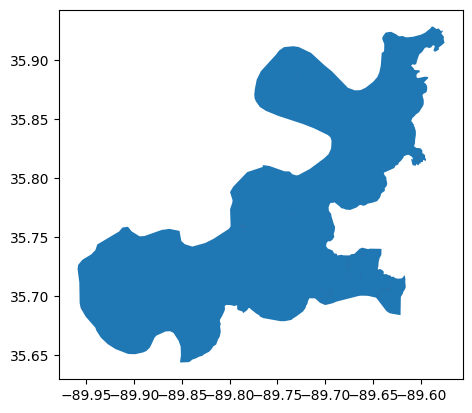

In [46]:
ax = percentages_census_df.query("GEOID == @test_geoid").plot()
buildings_in_area.query("GEOID == @test_geoid").plot(ax=ax, color='red')

In [47]:
buildings_in_area

,release,capture_dates_range,geometry,index_right,GEOID,tract,total_employee_count
97465,2,2/10/2016-10/17/2017,"POLYGON ((-88.59743 35.49367, -88.59753 35.493...",40,470239701011,970101,5.0
97485,2,2/10/2016-10/17/2017,"POLYGON ((-88.59951 35.49675, -88.59965 35.496...",40,470239701011,970101,5.0
97829,2,2/10/2016-10/17/2017,"POLYGON ((-88.62527 35.50127, -88.62542 35.501...",40,470239701011,970101,5.0
97965,2,2/10/2016-10/17/2017,"POLYGON ((-88.65378 35.49888, -88.65374 35.498...",40,470239701011,970101,5.0
97991,2,2/10/2016-10/17/2017,"POLYGON ((-88.65651 35.50149, -88.65640 35.501...",40,470239701011,970101,5.0
...,...,...,...,...,...,...,...
3032496,2,5/1/2020-5/9/2020,"POLYGON ((-90.00251 35.04795, -90.00251 35.048...",694,471570220253,022025,8.0
3091601,2,5/1/2020-5/9/2020,"POLYGON ((-90.00134 35.04940, -90.00135 35.049...",694,471570220253,022025,8.0
3091620,2,5/1/2020-5/9/2020,"POLYGON ((-90.00245 35.04683, -90.00233 35.046...",694,471570220253,022025,8.0
3210232,2,5/1/2020-5/9/2020,"POLYGON ((-90.00435 35.04993, -90.00484 35.049...",694,471570220253,022025,8.0


# Generating origin requests
* Loop through blocks
    * for each employee, 
    * randomly select a building inside the block and get its centroid
    * allocate a user id to the user and assign their home to this building id with centroid.

> TODO: Project to a projected CRS first

In [48]:
buildings_in_area[buildings_in_area['GEOID'] == '470970501001']

,release,capture_dates_range,geometry,index_right,GEOID,tract,total_employee_count
105719,2,9/9/2019-9/15/2019,"POLYGON ((-89.61791 35.70505, -89.61802 35.705...",0,470970501001,050100,4.0
105744,2,9/9/2019-9/15/2019,"POLYGON ((-89.60305 35.81520, -89.60299 35.815...",0,470970501001,050100,4.0
105797,2,9/9/2019-9/15/2019,"POLYGON ((-89.62864 35.71491, -89.62852 35.714...",0,470970501001,050100,4.0
105887,2,9/9/2019-9/15/2019,"POLYGON ((-89.64217 35.70294, -89.64200 35.702...",0,470970501001,050100,4.0
105888,2,9/9/2019-9/15/2019,"POLYGON ((-89.64226 35.70590, -89.64230 35.705...",0,470970501001,050100,4.0
...,...,...,...,...,...,...,...
3199874,2,9/9/2019-9/15/2019,"POLYGON ((-89.67634 35.72015, -89.67641 35.720...",0,470970501001,050100,4.0
3200067,2,9/9/2019-9/15/2019,"POLYGON ((-89.67400 35.72715, -89.67392 35.727...",0,470970501001,050100,4.0
3200451,2,9/9/2019-9/15/2019,"POLYGON ((-89.70240 35.69384, -89.70228 35.693...",0,470970501001,050100,4.0
3202525,2,9/9/2019-9/15/2019,"POLYGON ((-89.78521 35.75933, -89.78519 35.759...",0,470970501001,050100,4.0


In [49]:
columns = ["GEO_ID", "GEOID", "state", "county", "tract", "block group", "geometry", "total_employee_count"]
tdf = percentages_census_df[columns]
employee_counts = 0
user_requests = []
for k, v in tdf.iterrows():
    total_employees = int(v['total_employee_count'])
    geoid = v["GEOID"]
    building_df = buildings_in_area[buildings_in_area['GEOID'] == geoid]
    
    if building_df.empty:
        logger.error(f"ID: {geoid} has no buildings on record, using default centroid and building_id of 0.")
        default_df = percentages_census_df[percentages_census_df["GEOID"] == geoid].iloc[0]
        default_dict = {
            'release': 2,
            'capture_dates_range': '2/10/2016-10/17/2017',
            'geometry': default_df.geometry,
            'index_right': -1,
            'GEOID': 'geoid',
            'tract': default_df.tract,
            'total_employee_count': total_employees,
            'centroid': default_df.geometry.centroid,
            'user_id': -1,
            'building_id': 0
        }
        building_df = pd.DataFrame(default_dict, index=[0])

    # else:
    homes = building_df.sample(total_employees, replace=True)
    homes['centroid'] = homes.centroid
    homes['user_id'] = range(employee_counts, employee_counts + total_employees)
    homes['building_id'] = homes.index
    user_requests.append(homes)

    employee_counts += total_employees
    

/tmp/ipykernel_724981/318488575.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  homes['centroid'] = homes.centroid
/tmp/ipykernel_724981/318488575.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  homes['centroid'] = homes.centroid
/tmp/ipykernel_724981/318488575.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  homes['centroid'] = homes.centroid
/tmp/ipykernel_724981/318488575.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this opera

In [50]:
all_user_requests = pd.concat(user_requests)
all_user_requests = all_user_requests.drop(columns=["geometry"])
all_user_requests = gpd.GeoDataFrame(all_user_requests, geometry="centroid")
all_user_requests.to_file("./data/generated_user_requests_from_population.geojson")

In [51]:
all_user_requests = gpd.GeoDataFrame(all_user_requests, geometry='centroid')

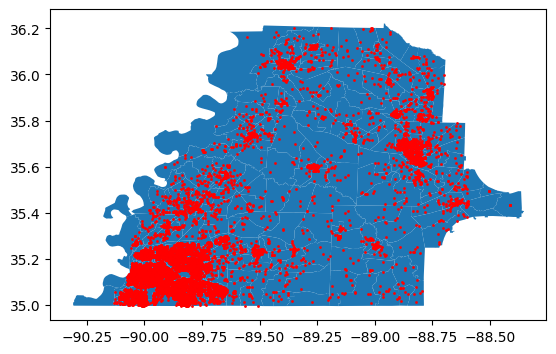

In [52]:
# Plotting heatmap for a data# Load the data
blocks = gpd.read_file("./data/processed_block_age_sex.geojson")
# census_data_df.plot()
ax = blocks.plot()
all_user_requests.plot(markersize=1, color='red', ax=ax)
plt.savefig('./output/out.png', dpi=200)